# Exploratatory Analysis of the GECKO-A data set

Before we can apply any machine learning techniques, we must gather, prepare and explore the data available. Data is almost always presented in a way that makes building a model difficult if not impossible. This can be due to missing data, incorrect data types, variability in values between features that make modeling difficult, or any other number of reasons. We're going to start with loading the dataset. Then we will do some initial analysis of the data. How is it typed? What is the [Tukey 5-number Summary](https://machinelearningmastery.com/how-to-calculate-the-5-number-summary-for-your-data-in-python/#:~:text=The%20five%2Dnumber%20summary%2C%20or,for%20data%20with%20any%20distribution.)? How is the data distributed? Are the data in the features correlated? Then we move on to how we can scale and normalize the data to better help our algorithms solve for a model that can hopefully generalize well.

## Gathering the data

Data can be stored in a variety of ways with varying complexities and advantages. One very common way of storing data is as a csv file. CSV has the advantage of being human readable and easily accessible by a large variety of applications, but with the caveat that csv files do not necessarily distinguish between text and numeric data. Data is also not typed so you cannot assume your application will automatically be able to distinguish between int, float, bool, text, etc.

We will begin by loading a csv file into a pandas data frame. This will make it easier to explore the data as well as set the type for each column of data.

GECKO-A runs simulations of precursors under a variety of different conditions for 5 days at 5 minute increments. It would be overwhelming to start with a large dataset so we will start by only loading experiment 1000 for the toluene precursor.

**Note I want to ask about what DJ and John would like me to start with. Should I start with raw data or maybe just a single csv and doctor it up a little to run through changing data type and such in the tutorial?**
**Note that in the future I am going to want to implement a way to publicly retrieve this data. Also it may be stored in the parquet format rather than csv**

In [11]:
# We will need several popular data science tools for this notebook
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn
import sklearn.decomposition
import scipy
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
file_path = "/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/ML2019_toluene_ML2019_Exp0.csv"

We can load the data using pandas built-in "read_csv" function and take a peek using the pd.head() function. 

In [3]:
dataFrame = pd.read_csv(file_path)
dataFrame.head()

,Time [s],Precursor [ug/m3],Temperature [K],OH [molec/cm3],O3 [molec/cm3],NOx [molec/cm3],SZA [degree],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,...,N/C Bin05: lg(C*) = -2.5,N/C Bin06: lg(C*) = -1.5,N/C Bin07: lg(C*) = -0.5,N/C Bin08: lg(C*) = 0.5,N/C Bin09: lg(C*) = 1.5,N/C Bin10: lg(C*) = 2.5,N/C Bin11: lg(C*) = 3.5,N/C Bin12: lg(C*) = 4.5,N/C Bin13: lg(C*) = 5.5,N/C Bin14: lg(C*) = 6.5
0,1.000000,0.037689,305.065338,4259464.0,2.131903e+12,4.663982e+10,156.839686,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,301.207794,0.037426,305.065338,4259464.0,2.131903e+12,3.089762e+11,156.845342,2.767639e-17,5.465436e-13,1.420820e-12,...,0.375269,0.150466,0.130869,0.217499,0.044273,0.143699,0.034506,0.116983,0.085254,0.001406
2,601.415588,0.037164,304.978027,4259464.0,2.131903e+12,3.365964e+11,156.787255,2.772026e-17,5.440976e-13,1.415403e-12,...,0.268998,0.065862,0.089287,0.223470,0.054207,0.144145,0.061240,0.104048,0.067545,0.002854
3,901.623352,0.036904,304.890747,4259464.0,2.131903e+12,3.391282e+11,156.665902,2.772170e-17,5.417454e-13,1.413397e-12,...,0.262669,0.028949,0.085632,0.228509,0.060956,0.144688,0.077644,0.096273,0.060124,0.004168
4,1201.831177,0.036646,304.803558,4259464.0,2.131903e+12,3.390159e+11,156.482265,2.803421e-17,5.397588e-13,1.422216e-12,...,0.262418,0.017990,0.097729,0.232256,0.068225,0.145245,0.087567,0.091117,0.056559,0.005371


Already we can see what columns are included in the data and get an idea of variablity in scale. Let's do some further formal investigation.

To see all the info available about a data frame you can use the built-in info function. We can see that all the data is fortuntately typed as float data. 

In [4]:
# Uncomment to see info about this dataframe
# dataFrame.info(verbose=True)

A really simple way to get idea of scale of date is to use the describe function.

In [11]:
dataFrame.describe()

,Time [s],Precursor [ug/m3],Temperature [K],OH [molec/cm3],O3 [molec/cm3],NOx [molec/cm3],SZA [degree],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,...,N/C Bin05: lg(C*) = -2.5,N/C Bin06: lg(C*) = -1.5,N/C Bin07: lg(C*) = -0.5,N/C Bin08: lg(C*) = 0.5,N/C Bin09: lg(C*) = 1.5,N/C Bin10: lg(C*) = 2.5,N/C Bin11: lg(C*) = 3.5,N/C Bin12: lg(C*) = 4.5,N/C Bin13: lg(C*) = 5.5,N/C Bin14: lg(C*) = 6.5
count,1440.000000,1440.000000,1440.000000,1440.0,1.440000e+03,1.440000e+03,1440.000000,1.440000e+03,1.440000e+03,1.440000e+03,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,216000.499985,0.003730,305.065668,4259464.0,2.131903e+12,3.404518e+11,90.025474,2.020035e-13,5.552691e-11,1.082034e-09,...,0.250765,0.012413,0.193415,0.202299,0.179024,0.280471,0.216452,0.066866,0.120035,0.051364
std,124837.355722,0.007517,2.828432,0.0,0.000000e+00,1.568655e+10,43.876241,1.838098e-13,4.849927e-11,9.527522e-10,...,0.009350,0.027107,0.079820,0.008710,0.022738,0.041761,0.050952,0.005469,0.017340,0.020496
min,1.000000,0.000002,301.065674,4259464.0,2.131903e+12,4.663982e+10,23.114540,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,108000.751953,0.000019,302.240440,4259464.0,2.131903e+12,3.270024e+11,49.482060,3.755645e-14,1.202481e-11,2.401389e-10,...,0.245620,0.000809,0.125366,0.200031,0.165739,0.267155,0.212162,0.062393,0.112511,0.036562
50%,216000.500000,0.000241,305.065338,4259464.0,2.131903e+12,3.404266e+11,90.031600,1.322379e-13,3.806870e-11,7.249040e-10,...,0.250533,0.001997,0.181451,0.200192,0.178251,0.300545,0.243162,0.065821,0.122608,0.047585
75%,324000.242188,0.003011,307.891029,4259464.0,2.131903e+12,3.542836e+11,130.570466,3.704593e-13,1.008944e-10,1.960206e-09,...,0.254498,0.009157,0.242689,0.201136,0.187446,0.308967,0.250291,0.072183,0.130578,0.062983
max,432000.000000,0.037689,309.065674,4259464.0,2.131903e+12,3.601407e+11,156.897517,5.492116e-13,1.487578e-10,2.999862e-09,...,0.375269,0.150466,0.382178,0.240436,0.246211,0.311665,0.263808,0.116983,0.152956,0.099788


We can so far see that there are 133 features in this matrix of data, there are 1440 time steps and the data is not well distributed at all. We won't be using columns 35 through 132 so we can drop those.

In [136]:
dataFrame = dataFrame[dataFrame.columns[0:35]]

There are a few ways we can distribute the data a little better. It's much easier to work with something that follows somewhat of a gaussian distribution. Like the following distribution with a mean of 0 and a variance of 1.

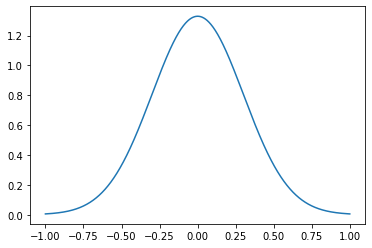

In [138]:
x_axis = np.arange(-1, 1, 0.001)
plt.plot(x_axis, stats.norm.pdf(x_axis,0,0.3))
plt.show()

## Data Preparation: Normalizing data

It's important to normalize and scale data because it makes it easier to solve for a local minima when evaluating the surface of the cost function for our model using gradient descent. Think of normalizing as smoothing the surface of the cost function. More information on scaling and normalizing [here.](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35#:~:text=Feature%20scaling%20is%20essential%20for,that%20calculate%20distances%20between%20data.&text=Since%20the%20range%20of%20values,not%20work%20correctly%20without%20normalization.)

### A visual of scaling effects

Let's plot the values for precursor for a single experiment.

In [92]:
def plot_feature(data, x_axis, y_axis, title):
    _ = plt.plot(data)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)

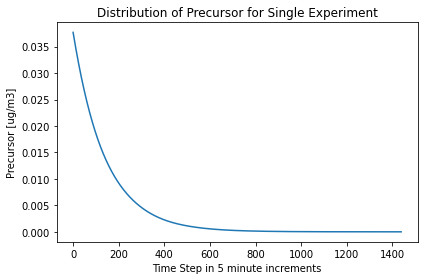

In [70]:
precursor = dataFrame[dataFrame.columns[1:2]]
plot_feature(data=precursor,x_axis="Time Step in 5 minute increments",y_axis="Precursor [ug/m3]", title="Distribution of Precursor for Single Experiment")

Notice that precursor follows an exponential decay distribution. How about we take a look at another column. Let's look at temperature next.

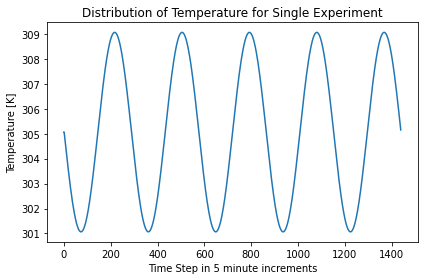

In [71]:
temperature = dataFrame[dataFrame.columns[2:3]]
plot_feature(data=temperature,x_axis="Time Step in 5 minute increments",y_axis="Temperature [K]", title="Distribution of Temperature for Single Experiment")

We can see that amount of precursor and temperature follow very different types of distributions and the scale of this data is much different. Let's explore some of the ways we can better distribute this data.

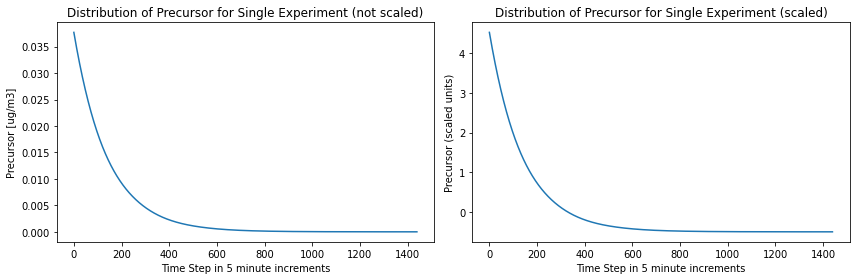

In [101]:
precursor = dataFrame[dataFrame.columns[1:2]]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_feature(data=precursor,x_axis="Time Step in 5 minute increments",y_axis="Precursor [ug/m3]", title="Distribution of Precursor for Single Experiment (not scaled)")

precursor_standardized = StandardScaler().fit_transform(precursor)
plt.subplot(1,2,2)

plot_feature(data=precursor_standardized,x_axis="Time Step in 5 minute increments",y_axis="Precursor (scaled units)", title="Distribution of Precursor for Single Experiment (scaled)")

plt.tight_layout()
plt.show()

We can also plot precursor as a function of time and again notice the scale. 

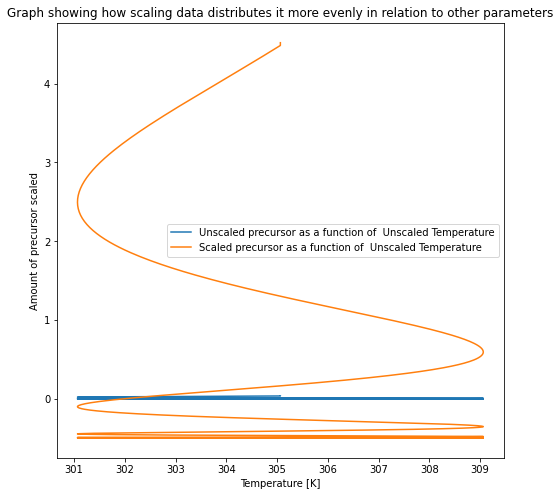

In [134]:
plt.figure(figsize=(8,8))
plt.plot(temperature.values, precursor.values,label="Unscaled precursor as a function of  Unscaled Temperature")

precursor_standardized = StandardScaler().fit_transform(precursor)
plt.plot(temperature, precursor_standardized, label="Scaled precursor as a function of  Unscaled Temperature")
plt.legend(loc="best")
plt.xlabel("Temperature [K]")
plt.ylabel("Amount of precursor scaled")
plt.title("Graph showing how scaling data distributes it more evenly in relation to other parameters")
plt.show()

How can we visualize all parameters in relation to eachother though? We can plot a histogram of all the data.

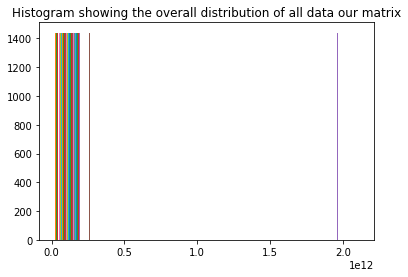

In [147]:
_ = plt.hist(dataFrame)
plt.title("Histogram showing the overall distribution of all data our matrix")
plt.show()

We can use sklearns StandardScaler.fit_transform() function to perform a z-score standarization which will normalize the data so it follows an overall normal distribution.

In [144]:
dataFrame_standardized = StandardScaler().fit_transform(dataFrame)

Now if we plot the data we get a distribution that more closely resembles a standard normal distribution.

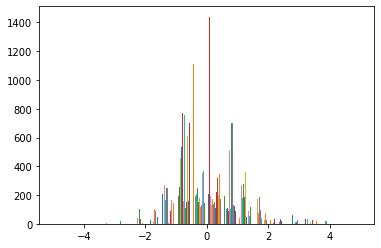

In [148]:
_ = plt.hist(dataFrame_standardized, bins = 20, range = [-5,5])

This is only one type of standardization method called Z-score standardization and is represented in the following way:

$x' = \frac{x - \bar{x}}{\sigma}$ , where ${x}$ is the original feature vector, ${\bar {x}}={\text{average}(x)}$ is the mean of that feature vector, and ${\displaystyle \sigma }$ is its standard deviation.

There are many other types of scaling and normalization techniques.

# Further analysis (PCA)

One way to transform data is by performing PCA. PCA reduces the dimension of the data matrix making it easier to both visualize and later use in machine learning algorithms such as linear regression. 

We can start with a really simple example before moving on to the data set we will be using for these tutorials.

### Example PCA (predicting flower speces)

Suppose you want to be able to predict flower speces based on number of features. Let's say we have available: (sepal length, sepal width, petal length, petal width, and a target flower that goes with each row of data). We might have the following data:

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
dataFrame_flowers = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
dataFrame_flowers.tail(5)

,sepal length,sepal width,petal length,petal width,target
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


We can't visualize the feature matrix X because it is currently a 150 by 4 dimensional matrix. We can however use principal component analysis to reduce the dimension of the matrix and visualize it.

### Caveat to PCA

You must normalize/scale your data before applying PCA. If you do not normalize your data to have the same standard deviation for all features, some data will be weighted disporportionately. After you fit PCA, you will generate a list of principal components specified when you fit the data. You can reduce the dimension of your data from the $(n \times m)$ matrix where n represents number of rows and m represents number of features to $(n \times k)$ where n represents the number of rows of data and k represents the number of components you want to reduce your data to. This allows you to visualize data by reducing the dimension. It also can help you solve machine learning algorithms like linear regression faster. When you reduce the dimension, you are also reducing the amount of information available to perform ML. This can be a problem if the cummulative explained variance drops below a certain threshold. Let's examine the effects of PCA with a really simple example before moving on to performing PCA on our dataset. 

In [13]:
X = dataFrame_flowers[dataFrame_flowers.columns[0:4]]
X_scaled = StandardScaler().fit_transform(X)

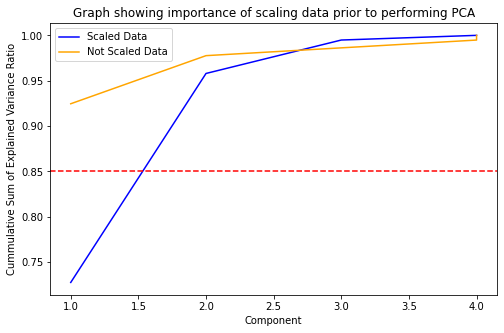

In [6]:
X = dataFrame_flowers[dataFrame_flowers.columns[0:4]]
X_scaled = StandardScaler().fit_transform(X)
pca_X_scaled = PCA().fit(X_scaled)
plt.figure(figsize=(8,5))

pca_X_not_scaled = PCA().fit(X)
_ = plt.plot([1,2,3,4], np.cumsum(pca_X_scaled.explained_variance_ratio_), color='blue', label="Scaled Data")
_ = plt.plot([1,2,4,4], np.cumsum(pca_X_not_scaled.explained_variance_ratio_), color = 'orange', label="Not Scaled Data" )
plt.axhline(0.85, color="red", linestyle = "--")
plt.legend(loc="best")
plt.xlabel("Component")
plt.ylabel("Cummulative Sum of Explained Variance Ratio")
plt.title("Graph showing importance of scaling data prior to performing PCA")
plt.show()

As you can see, if we did not scale our data before performing PCA we under-estimated the number of components we would need to explain the variance ratio. The explained variance is essentially the information pertitent to predicting. A common "rule-of-thumb" is that you need at least enough components to explain 85% of the total explained variance. So we see that even with just two components we can explain more than 95% of the data variance. We have reduced the number of components needed to predict the target at some small expense to accuracy. Now we can visualize the data. Let's plot a 2D histogram of our first and second principal components.

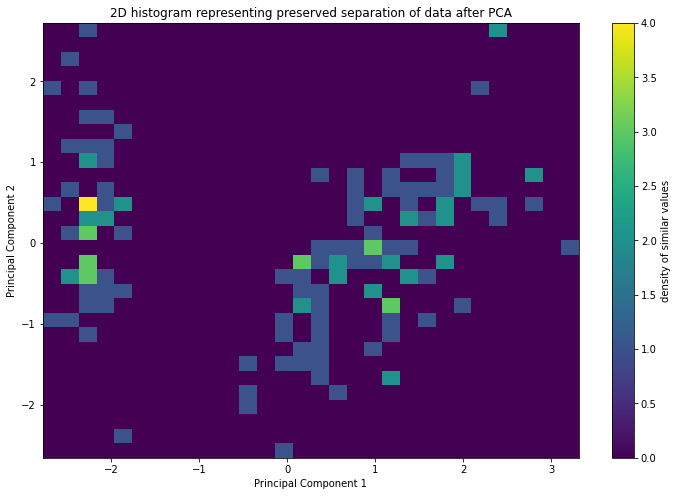

In [9]:
X_pca_scaled = PCA().fit_transform(X_scaled)
plt.figure(figsize = (12,8))
_ = plt.hist2d(X_pca_scaled[:,0], X_pca_scaled[:,1], bins = 30)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("2D histogram representing preserved separation of data after PCA")
cb = plt.colorbar()
cb.set_label('density of similar values')

We can see that the data resolves to at least two clearly defined regions. We can next plot a scatter plot to further visualize how PCA can reduce the amount of data needed to predict targets. Let's plot a scatter plot and assign a color based on the corresponding target for each data point.

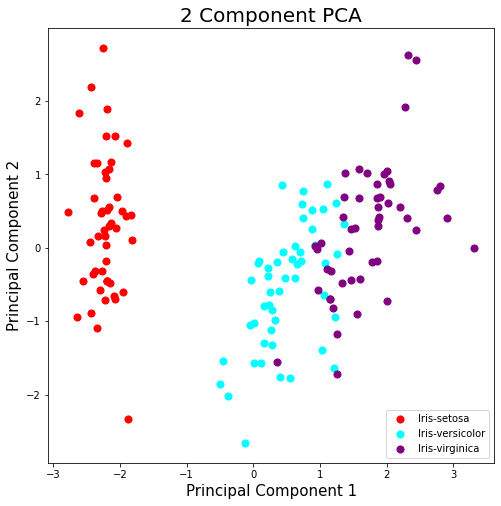

In [170]:
flowertypes = {'Iris-setosa': 'red','Iris-versicolor': 'cyan', 'Iris-virginica': "purple"}

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

for index in dataFrame_flowers.index:
    target = dataFrame_flowers.iloc[index]["target"]
    ax.scatter(X_pca_scaled[index, 0], X_pca_scaled[index, 1], color = flowertypes[target], label = target, s = 50)
ax.legend(flowertypes.keys())
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('cyan')
leg.legendHandles[2].set_color('purple')
plt.show()

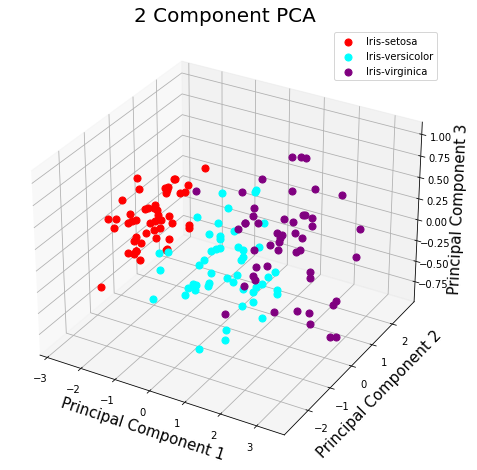

In [10]:
flowertypes = {'Iris-setosa': 'red','Iris-versicolor': 'cyan', 'Iris-virginica': "purple"}

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title('2 Component PCA', fontsize = 20)


for index in dataFrame_flowers.index:
    target = dataFrame_flowers.iloc[index]["target"]
    ax.scatter(X_pca_scaled[index, 0], X_pca_scaled[index, 1], X_pca_scaled[index,2], color = flowertypes[target], label = target, s = 50)
ax.legend(flowertypes.keys())
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('cyan')
leg.legendHandles[2].set_color('purple')
plt.show()

If we add the 3rd principal component it makes it marginally easier to distinguish data.

### Correlation Matrix

The final visualization we have at our disposal is a correlation matrix. By comparing the correlation matrix of X and the inverse transform of X after PCA we can observe the "smoothing" effect of applying PCA.

In [22]:
X_pca = PCA(n_components=2).fit(X)
X_inv_transform = X_pca.inverse_transform(X_pca.transform(X))
X_inv_transform = pd.DataFrame(data = X_inv_transform, columns=['sepal length','sepal width','petal length','petal width'])

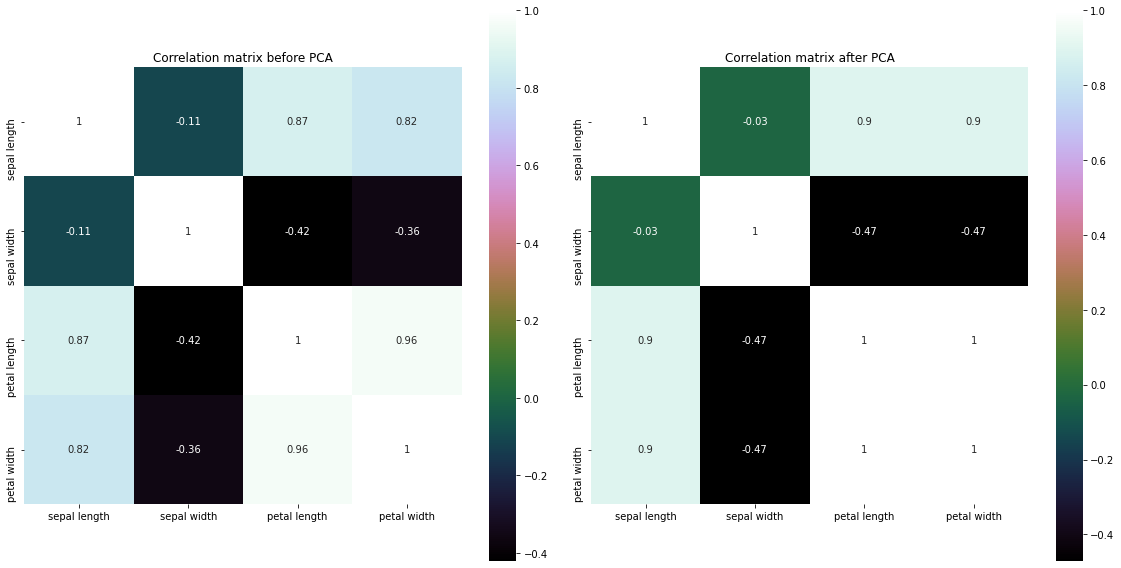

In [29]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
corr_mat = X.corr(method='pearson')
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title("Correlation matrix before PCA")

plt.subplot(1,2,2)

corr_mat = X_inv_transform.corr(method='pearson')
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title("Correlation matrix after PCA")

plt.tight_layout()
plt.show()

PCA

## Correlation Matrix

Now that we know some scaling methods we can go ahead and expand our data frame to include other experiments and do some further exploration by building a correlation matrix. This will help us determine what features my be linear combinations of other features. There is a technique called Principal component analysis that we can use to reduce the dimension of our data by abstracting away linearly correlated data. First lets build our dataset...

### Building our dataset

There is data from thousands of experiments but we will start with 2000 experiments. Each experiment contains 1440 rows of data so our dataset will contain about 2.9 million rows of data and be size 2,880,000 by 133, this will equate to about 4 GB of data so plan on leaving between 25 and 30 minutes to load this.

**Note this will have to be a publically available source in the future. Can change filepath parameter**

In [12]:
def load_data(start_index=0, end_index=2000):
    dataFrame = pd.DataFrame()
    progress = 0
    for index in range(start_index, end_index):
        file_path = f"/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/ML2019_toluene_ML2019_Exp{str(index)}.csv"
        dataFrame = dataFrame.append(pd.read_csv(file_path))
        progress += 1
        if progress % 100 == 0:
            print(progress, "experiments loaded")
    return dataFrame

This is going to take awhile...

In [13]:
# Just run pd.read_parquet() line if you dont want to build the dataset from scratch
# dataFrame = load_data()
dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999.parquet")

We can save time by just saving our dataFrame as a parquet file for next time we want to load it. This takes seconds to read and write vs minutes to build the dataframe each time.

In [14]:
dataFrame.columns

Index(['Time [s]', 'Precursor [ug/m3]', 'Temperature [K]', 'OH [molec/cm3]',
       'O3 [molec/cm3]', 'NOx [molec/cm3]', 'SZA [degree]',
       'Gas [ug/m3] Bin01: lg(C*) = -6.5', 'Gas [ug/m3] Bin02: lg(C*) = -5.5',
       'Gas [ug/m3] Bin03: lg(C*) = -4.5',
       ...
       'N/C Bin05: lg(C*) = -2.5', 'N/C Bin06: lg(C*) = -1.5',
       'N/C Bin07: lg(C*) = -0.5', 'N/C Bin08: lg(C*) =  0.5',
       'N/C Bin09: lg(C*) =  1.5', 'N/C Bin10: lg(C*) =  2.5',
       'N/C Bin11: lg(C*) =  3.5', 'N/C Bin12: lg(C*) =  4.5',
       'N/C Bin13: lg(C*) =  5.5',
       'N/C Bin14: lg(C*) =  6.5                                                                                                      '],
      dtype='object', length=133)

Notice there is a space before every column name. Let's get rid of that.

In [15]:
# rename_columns = {}
# for column in dataFrame.columns:
#     rename_columns[column] = column[1:]
    
# dataFrame = dataFrame.rename(columns=rename_columns)

In [16]:
# Save dataFrame containing experiments 0 through 1999 to parquet file
# dataFrame.to_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999.parquet")

In [17]:
# To read just use pd.read_parquet()
# dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999.parquet")

Something that hasn't been discussed is what data is actually needed from the dataframe. The ultimate goal is going to be predicting amount of precursor at t+1 based on available input. It's time to start thinking about what is needed to do that. We will use the following features as input in our model:

* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx $(molec/cm^3)$: concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 $(molec/cm^3)$: concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH $(molec/cm^3)$: concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.
* Gas binned data $(ug/m^3)$: concentration of gas concentration binned by level of volatility 
* Aerosol binned data $(ug/m^3)$: concentration of aerosol conctration binned by level of volatility

We will have to add pre-existing aerosol data to our dataset and we can remove all the bins except those for gas and aerosol. We also will want to add exp # to our data.

In [18]:
df_summary_data = pd.read_csv("/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/TOLUENE_Exp_List_ML2019_toluene_v1_LatinHyperCube.csv", skiprows=3)

df_summary_data contains the parameters for the geck-a runs that generated our data. 

In [19]:
df_summary_data.columns

Index(['id', ' temperature (K)', ' solar zenith angle (degree)',
       ' pre-existing aerosols (ug/m3)', ' o3 (ppb)', ' nox (ppb)',
       ' oh (10^6 molec/cm3)'],
      dtype='object')

In [20]:
dataFrame = dataFrame.reset_index(drop=True);

In [21]:
# dataFrame["id"] = "test"
# dataFrame["pre-existing aerosols (ug/m3)"] = 0.0
# for experiment in range(len(df_summary_data)):
#     lower_index = experiment * 1440
#     upper_index = lower_index + 1439

#     dataFrame.loc[lower_index:upper_index, "id"] = df_summary_data.loc[experiment, "id"]
#     dataFrame.loc[lower_index:upper_index, "pre-existing aerosols (ug/m3)"] = df_summary_data.loc[experiment, " pre-existing aerosols (ug/m3)"]

In [22]:
drop_list = ["Kh [M/atm] Bin01: lg(C*) = -6.5" , "Kh [M/atm] Bin02: lg(C*) = -5.5" , "Kh [M/atm] Bin03: lg(C*) = -4.5" , "Kh [M/atm] Bin04: lg(C*) = -3.5" , "Kh [M/atm] Bin05: lg(C*) = -2.5" , "Kh [M/atm] Bin06: lg(C*) = -1.5" , "Kh [M/atm] Bin07: lg(C*) = -0.5" , "Kh [M/atm] Bin08: lg(C*) =  0.5" , "Kh [M/atm] Bin09: lg(C*) =  1.5" , "Kh [M/atm] Bin10: lg(C*) =  2.5" , "Kh [M/atm] Bin11: lg(C*) =  3.5" , "Kh [M/atm] Bin12: lg(C*) =  4.5" , "Kh [M/atm] Bin13: lg(C*) =  5.5" , "Kh [M/atm] Bin14: lg(C*) =  6.5" , "MW [g/mol] Bin01: lg(C*) = -6.5" , "MW [g/mol] Bin02: lg(C*) = -5.5" , "MW [g/mol] Bin03: lg(C*) = -4.5" , "MW [g/mol] Bin04: lg(C*) = -3.5" , "MW [g/mol] Bin05: lg(C*) = -2.5" , "MW [g/mol] Bin06: lg(C*) = -1.5" , "MW [g/mol] Bin07: lg(C*) = -0.5" , "MW [g/mol] Bin08: lg(C*) =  0.5" , "MW [g/mol] Bin09: lg(C*) =  1.5" , "MW [g/mol] Bin10: lg(C*) =  2.5" , "MW [g/mol] Bin11: lg(C*) =  3.5" , "MW [g/mol] Bin12: lg(C*) =  4.5" , "MW [g/mol] Bin13: lg(C*) =  5.5" , "MW [g/mol] Bin14: lg(C*) =  6.5" , "dH [J/mol] Bin01: lg(C*) = -6.5" , "dH [J/mol] Bin02: lg(C*) = -5.5" , "dH [J/mol] Bin03: lg(C*) = -4.5" , "dH [J/mol] Bin04: lg(C*) = -3.5" , "dH [J/mol] Bin05: lg(C*) = -2.5" , "dH [J/mol] Bin06: lg(C*) = -1.5" , "dH [J/mol] Bin07: lg(C*) = -0.5" , "dH [J/mol] Bin08: lg(C*) =  0.5" , "dH [J/mol] Bin09: lg(C*) =  1.5" , "dH [J/mol] Bin10: lg(C*) =  2.5" , "dH [J/mol] Bin11: lg(C*) =  3.5" , "dH [J/mol] Bin12: lg(C*) =  4.5" , "dH [J/mol] Bin13: lg(C*) =  5.5" , "dH [J/mol] Bin14: lg(C*) =  6.5" , "kOH [cm3/molec/s] Bin01: lg(C*) = -6.5" , "kOH [cm3/molec/s] Bin02: lg(C*) = -5.5" , "kOH [cm3/molec/s] Bin03: lg(C*) = -4.5" , "kOH [cm3/molec/s] Bin04: lg(C*) = -3.5" , "kOH [cm3/molec/s] Bin05: lg(C*) = -2.5" , "kOH [cm3/molec/s] Bin06: lg(C*) = -1.5" , "kOH [cm3/molec/s] Bin07: lg(C*) = -0.5" , "kOH [cm3/molec/s] Bin08: lg(C*) =  0.5" , "kOH [cm3/molec/s] Bin09: lg(C*) =  1.5" , "kOH [cm3/molec/s] Bin10: lg(C*) =  2.5" , "kOH [cm3/molec/s] Bin11: lg(C*) =  3.5" , "kOH [cm3/molec/s] Bin12: lg(C*) =  4.5" , "kOH [cm3/molec/s] Bin13: lg(C*) =  5.5" , "kOH [cm3/molec/s] Bin14: lg(C*) =  6.5" , "O/C Bin01: lg(C*) = -6.5" , "O/C Bin02: lg(C*) = -5.5" , "O/C Bin03: lg(C*) = -4.5" , "O/C Bin04: lg(C*) = -3.5" , "O/C Bin05: lg(C*) = -2.5" , "O/C Bin06: lg(C*) = -1.5" , "O/C Bin07: lg(C*) = -0.5" , "O/C Bin08: lg(C*) =  0.5" , "O/C Bin09: lg(C*) =  1.5" , "O/C Bin10: lg(C*) =  2.5" , "O/C Bin11: lg(C*) =  3.5" , "O/C Bin12: lg(C*) =  4.5" , "O/C Bin13: lg(C*) =  5.5" , "O/C Bin14: lg(C*) =  6.5" , "H/C Bin01: lg(C*) = -6.5" , "H/C Bin02: lg(C*) = -5.5" , "H/C Bin03: lg(C*) = -4.5" , "H/C Bin04: lg(C*) = -3.5" , "H/C Bin05: lg(C*) = -2.5" , "H/C Bin06: lg(C*) = -1.5" , "H/C Bin07: lg(C*) = -0.5" , "H/C Bin08: lg(C*) =  0.5" , "H/C Bin09: lg(C*) =  1.5" , "H/C Bin10: lg(C*) =  2.5" , "H/C Bin11: lg(C*) =  3.5" , "H/C Bin12: lg(C*) =  4.5" , "H/C Bin13: lg(C*) =  5.5" , "H/C Bin14: lg(C*) =  6.5" , "N/C Bin01: lg(C*) = -6.5" , "N/C Bin02: lg(C*) = -5.5" , "N/C Bin03: lg(C*) = -4.5" , "N/C Bin04: lg(C*) = -3.5" , "N/C Bin05: lg(C*) = -2.5" , "N/C Bin06: lg(C*) = -1.5" , "N/C Bin07: lg(C*) = -0.5" , "N/C Bin08: lg(C*) =  0.5" , "N/C Bin09: lg(C*) =  1.5" , "N/C Bin10: lg(C*) =  2.5" , "N/C Bin11: lg(C*) =  3.5" , "N/C Bin12: lg(C*) =  4.5" , "N/C Bin13: lg(C*) =  5.5" , "N/C Bin14: lg(C*) =  6.5                                                                                                      "]

In [23]:
dataFrame = dataFrame.drop(columns = drop_list)

In [24]:
# dataFrame.to_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999_post_proc.parquet")

In [2]:
dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999_post_proc.parquet")

### Correlation

In [80]:
# We can remove the time domain before constructing a correlation matrix
dataFrame_corr = dataFrame.drop(columns = ["Time [s]", "id"])

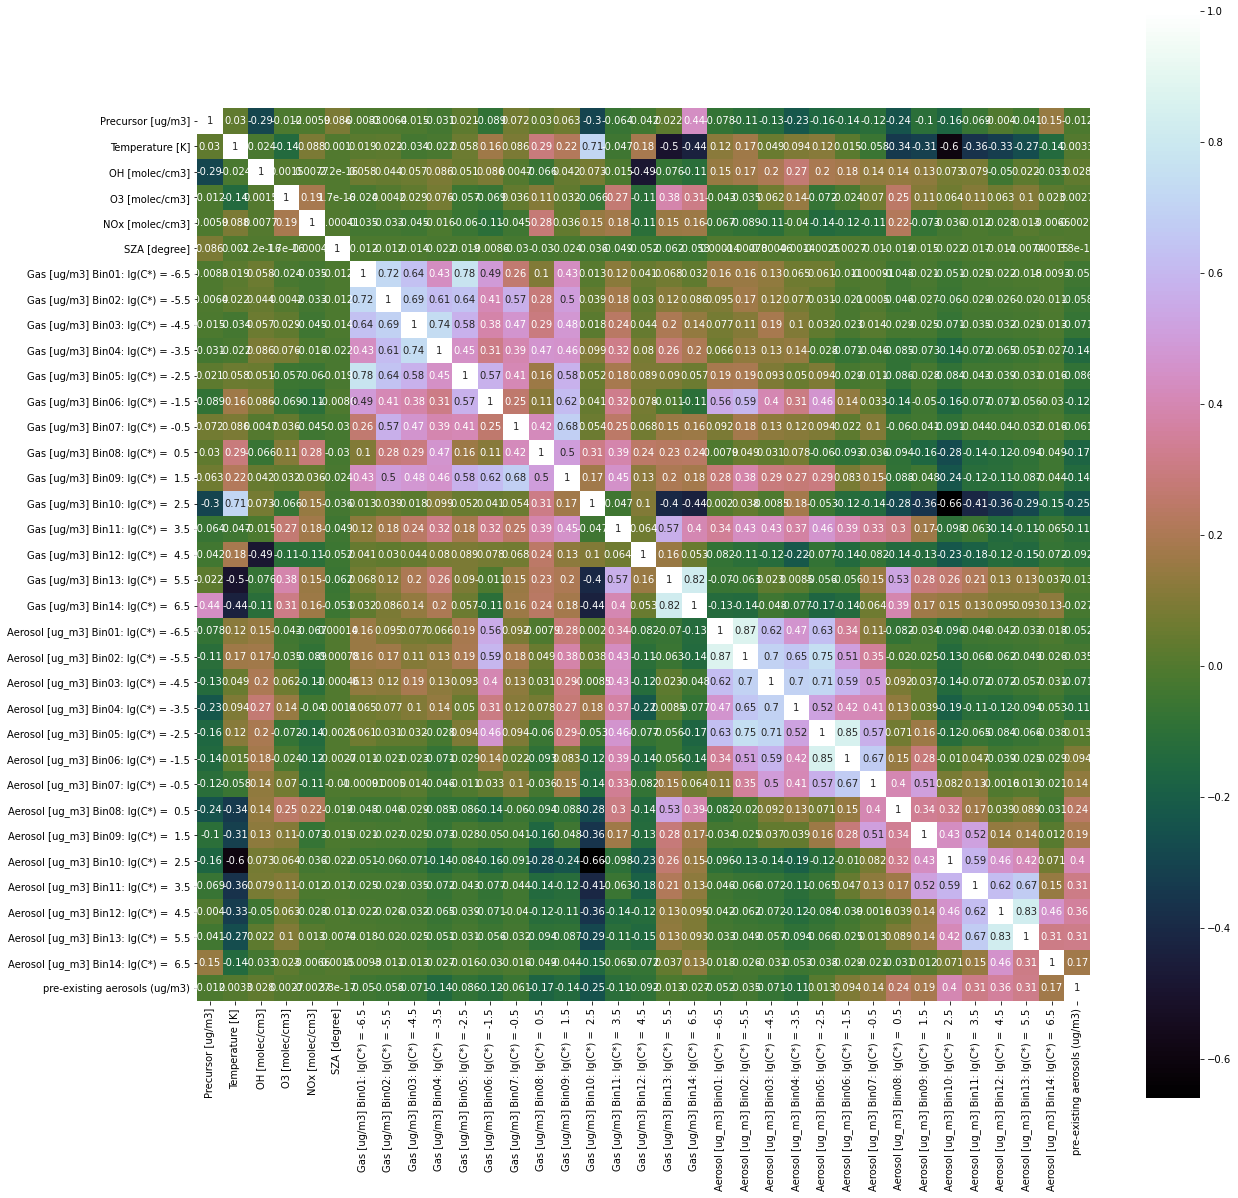

In [83]:
corr_mat = dataFrame_corr.corr(method='pearson')
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.savefig("./correlation_matrix.pdf")

**TODO: What can we say about the correlation matrix? What is there left to explore?**

https://builtin.com/data-science/step-step-explanation-principal-component-analysis

### PCA Analysis of Binned Gas data and Aerosol Data

* normalize data first 

* explained variance ratio
    - How much does each component explain the variance
    - compare the original data and inverse tranform after PCA
    

* heat map

Because the correlation matrix suggests some values like the Gas binned data 1 through 9 is correlated there may be reason to try PCA analysis as a way to reduce the dimension of our feature matrix. PCA is a way of essentially smoothing out the surface represented by the matrix of input features in our model. Sklearn contains a library of functions that can assist in performing PCA. One of the first things we can do is fit PCA and then transform the data **TODO**

Let's just perform PCA on the binned gas data and then the binned aerosol data. 

In [28]:
# count = 0
# for column in dataFrame.columns:
#     print(count, column)
#     count+=1

In [3]:
dataFrame_gas_binned = dataFrame[dataFrame.columns[7:21]]
dataFrame_aerosol_binned = dataFrame[dataFrame.columns[21:35]]

In [4]:
def plot_pca(data, x_max=10):
    plt.figure(figsize=(15,5))

    plt.plot(np.cumsum(data.explained_variance_ratio_), label = "combined gas and aersol data")
    plt.legend(loc='best')

    plt.xlim(0,x_max,0.5)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance ratio')
    plt.axhline(y = 0.85, color='r',linestyle='--' , linewidth=2)
    plt.show()
    plt.close()

In [32]:
X = dataFrame_flowers[dataFrame_flowers.columns[0:4]]
X_scaled = StandardScaler().fit_transform(X)

After scaling the data we can run the PCA algorithm and plot the explained variance for each component.

Plotting the cummulitive sum can help us visualize how much of the explained variance (information) each component represents.

**TODO: Change x-axis**

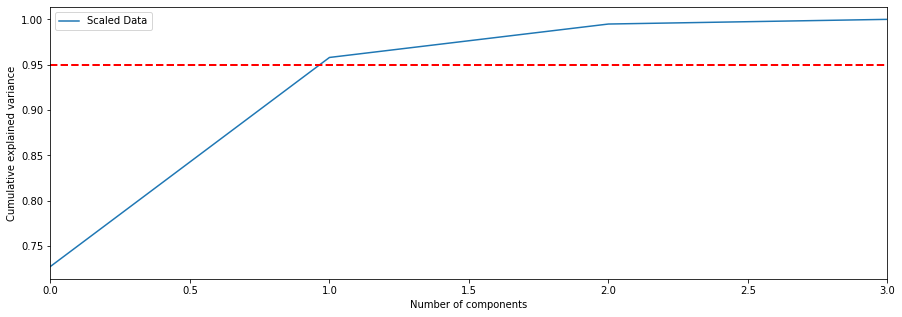

In [35]:
plt.figure(figsize=(15,5))

plt.plot(np.cumsum(pca_X_scaled.explained_variance_ratio_), label = "Scaled Data")
plt.legend(loc='best')

plt.xlim(0,3,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y = 0.95, color='r',linestyle='--' , linewidth=2)
plt.show()
plt.close()

If we scatter plot the data and color the data by the target it represents we can furter demonstrate how reducing the dimension of the feature matrix still preserves enough information to differentiate between correlated data.

In [39]:
dataFrame_scaled = pd.DataFrame(data = X_scaled, columns=['sepal length','sepal width','petal length','petal width'])

<AxesSubplot:>

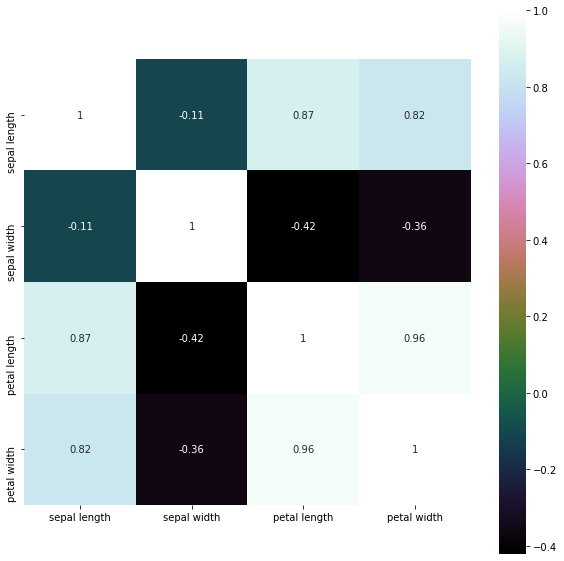

In [40]:
corr_mat = dataFrame_scaled.corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

Let's move on to doing the same exploration with the GECKO data. Specifically let's see if it's reasonable to reduce the dimension of the gas and aerosol data. 

First we will build a data frame of the gas and aeorsol data.

In [5]:
dataFrame = pd.read_parquet("/glade/work/ochaarawi/ML2019_toluene_ML2019_Exp_0_1999_post_proc.parquet")
gas_aerosol_dataFrame = dataFrame[dataFrame.columns[7:35]]

In [6]:
gas_aerosol_dataFrame_scaled = StandardScaler().fit_transform(gas_aerosol_dataFrame)
gas_aerosol_dataFrame_scaled_pca = PCA().fit(gas_aerosol_dataFrame_scaled)

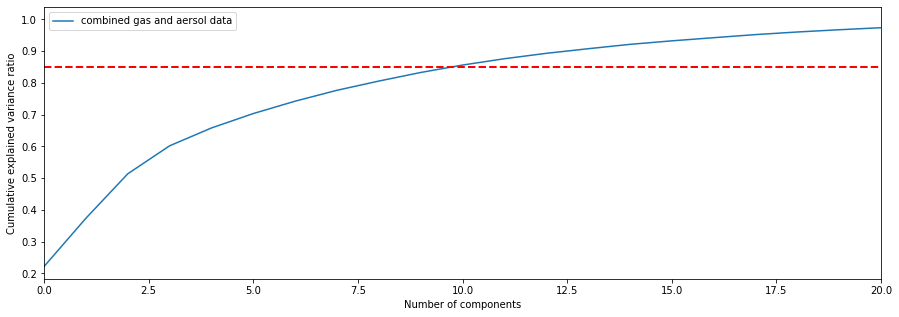

In [7]:
plot_pca(gas_aerosol_dataFrame_scaled_pca,20)

It's clear that 2 components is not enought to accurately predict because the first two components only account for about 50% of the explained variance. But what if we separate gas and aersol data?

**TODO: plot timeseries of 1st and 2nd principal components **

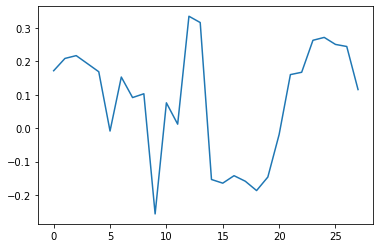

In [12]:
plt.plot(gas_aerosol_dataFrame_scaled_pca.components_[2])

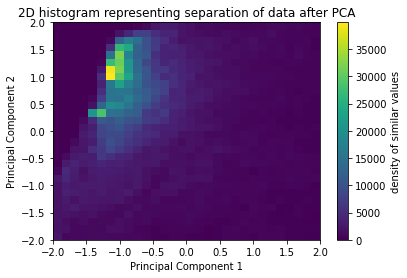

In [44]:
data = PCA().fit_transform(gas_aerosol_dataFrame_scaled)
plt.hist2d(data[:,0], data[:,1], bins = 30, range = [[-2, 2], [-2, 2]]);
cb = plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("2D histogram representing separation of data after PCA")
cb.set_label('density of similar values')


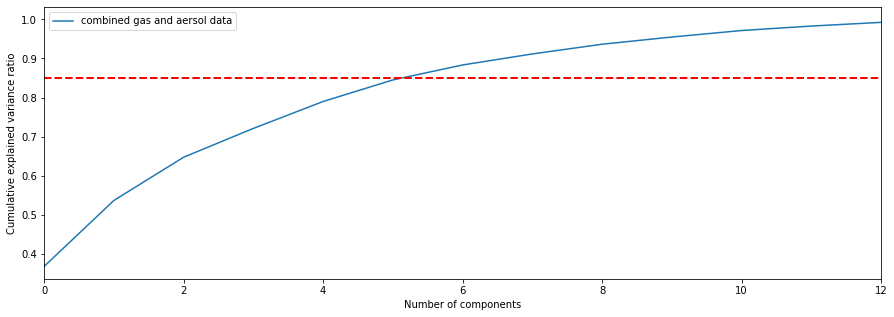

In [45]:
gas_dataFrame = dataFrame[dataFrame.columns[7:21]]
gas_dataFrame_scaled = StandardScaler().fit_transform(gas_dataFrame)
gas_dataFrame_scaled_pca = PCA().fit(gas_dataFrame_scaled)
plot_pca(gas_dataFrame_scaled_pca,12)

In [46]:
data = PCA().fit_transform(gas_dataFrame_scaled)

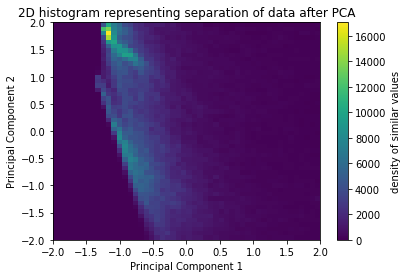

In [47]:
plt.hist2d(data[:,0], data[:,1], bins = 50, range = [[-2, 2], [-2, 2]]);
cb = plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("2D histogram representing separation of data after PCA")
cb.set_label('density of similar values')

Finally let's plot the complete matrix with all features.

In [67]:
X = dataFrame.drop(columns = ["Time [s]", "id"])

In [68]:
X_scaled = StandardScaler().fit_transform(X)
X_pca_scaled = PCA().fit(X_scaled)

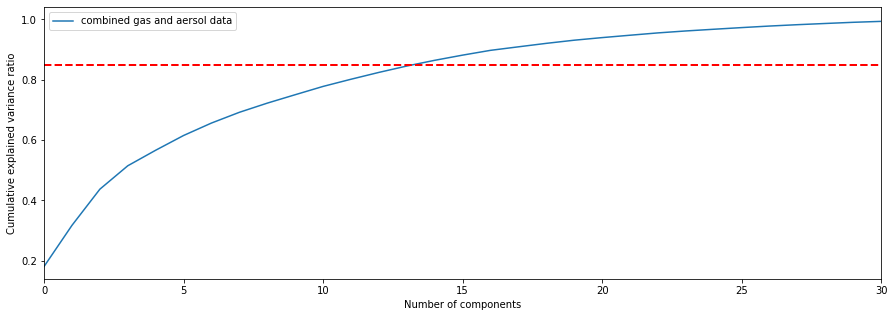

In [69]:
plot_pca(X_pca_scaled, 30)

In [51]:
data = X_pca_scaled.transform(X_scaled)

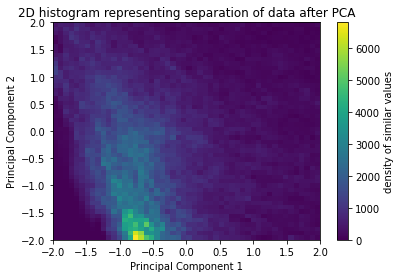

In [52]:
plt.hist2d(data[:,0], data[:,1], bins = 50, range = [[-2, 2], [-2, 2]]);
cb = plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("2D histogram representing separation of data after PCA")
cb.set_label('density of similar values')

In [75]:
X_pca_scaled = PCA(n_components=15).fit(X)
data = X_pca_scaled.transform(X)

In [76]:
data_original = X_scaled
data_inv_transform = X_pca_scaled.inverse_transform(data)

In [77]:
names = [name for name in X.columns]

In [78]:
dataFrame_inv_transform = pd.DataFrame(data = data_inv_transform, columns = names )

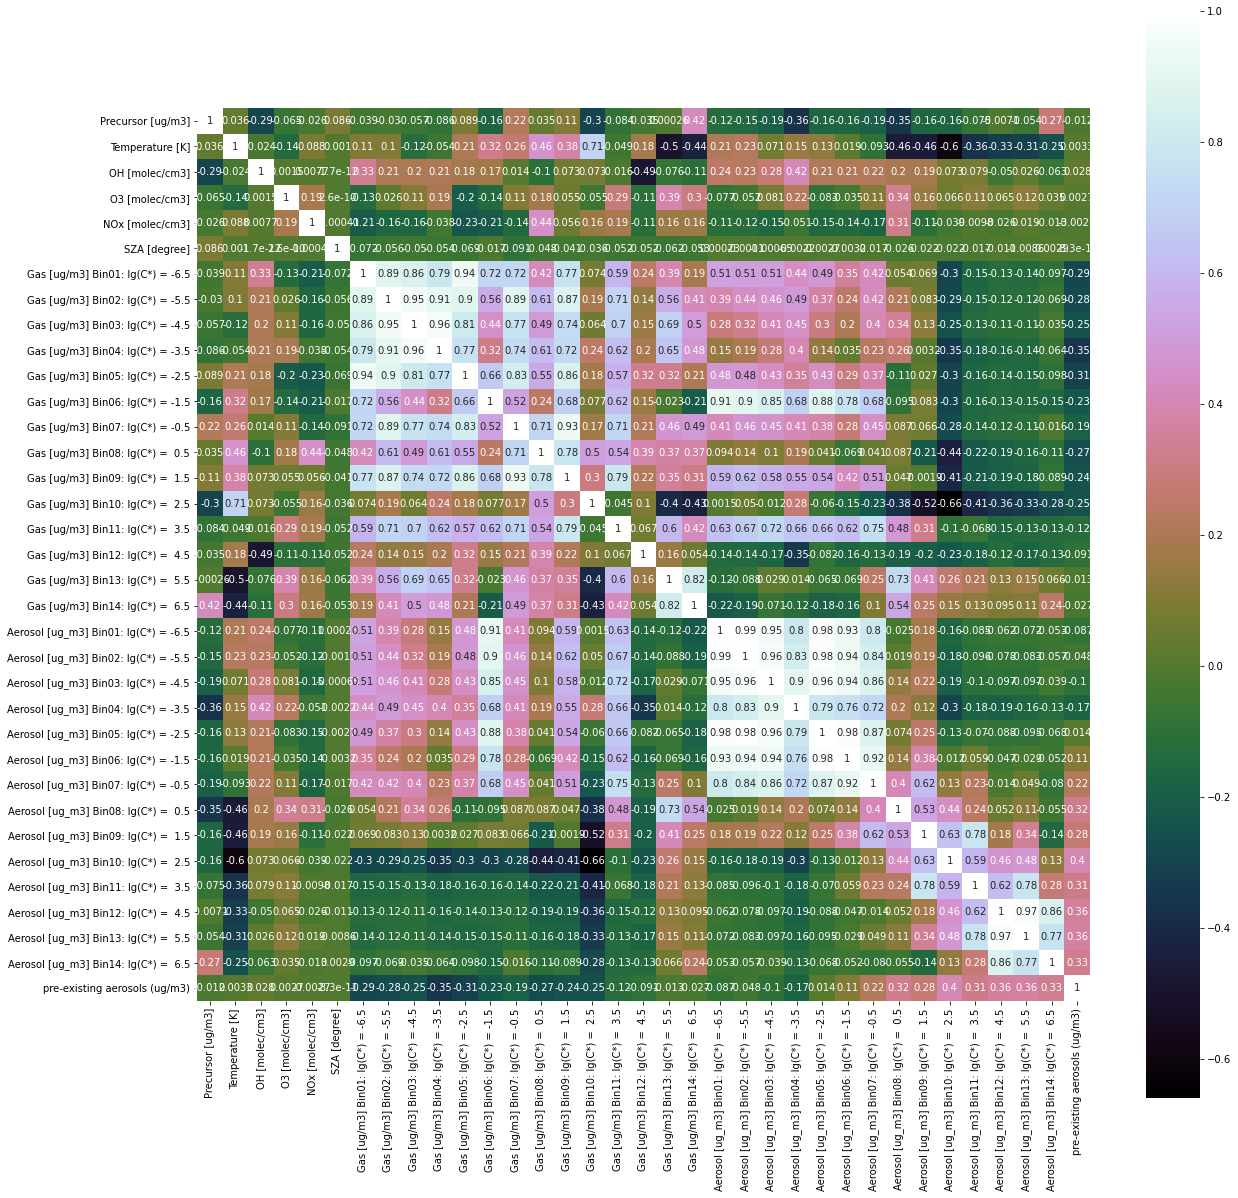

In [84]:
corr_mat = dataFrame_inv_transform.corr(method='pearson')
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.savefig("./correlation_matrix_post_pca15.pdf")